In [2]:
# Importing dependencies
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords


In [3]:
# reading in the data
data = pd.read_csv('data_cleaned_w_sentiment.csv')
data.head(2)

,date,id,name,text,location,mention,text_clean,tidy_tweet,tokenised,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,sentiment
0,2018-12-31,1079890357540843522,SocialMktgFella,Bitcoin History Part 7: The First Major Hack ...,"Orange County, CA",False,Bitcoin History Part 7: The First Major Hack ...,Bitcoin History Pa First Major Hack hps news b...,"['bitcoin', 'history', 'pa', 'first', 'major',...","['bitcoin', 'history', 'pa', 'first', 'major',...","['bitcoin', 'histori', 'pa', 'first', 'major',...","['bitcoin', 'history', 'pa', 'first', 'major',...",0.000
1,2018-12-31,1079923403518177280,JohnLilic,... but it’s not working. I love you all. Hap...,Global Coverage,False,... but it’s not working. I love you all. Hap...,working love Happy year bitcoin ethereum,"['working', 'love', 'happy', 'year', 'bitcoin'...","['working', 'love', 'happy', 'year', 'bitcoin'...","['work', 'love', 'happi', 'year', 'bitcoin', '...","['working', 'love', 'happy', 'year', 'bitcoin'...",0.836


In [4]:
# creating and expanding the stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'twier', 'pa', 'hps', 'com.', 'call', 'thing', 'not', 'make', 'do', 'be', 'even', 'rally', 'look', 'tnw', 'www.', 'www', 'not', 'be', 'not', 'do', 'come', 'week', 'ever', 'less', 'talk', 'try', 'recent', 'thing', 's', 'come', 'ebpg', 'subject', 're', 'edu', 'use', 'back', 'since', 'much', 'take', 'want', 'getting', 'please', 'years', 'also', 'need', 'still', '2019', '2018', 'think', 'today', 'currently', 'takes', 'within', 'year', 'going', 'cryptocurrencies', 'bitcoin', '000', 'know', 'first', 'could', 'like', 'would', 'time', 'pic', 'com', 'https', 'btc', 'html', 'chart', 'twitter', 'crypto', 'http', 'cryptocurrency', 'just', ])

In [5]:
# creating a list from the relevant column
df = data.tidy_tweet.values.tolist()

In [6]:
# Tokenizing words and Cleaning-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df))

print(data_words[:1])

[['bitcoin', 'history', 'pa', 'first', 'major', 'hack', 'hps', 'news', 'bitcoin', 'bitcoin', 'history', 'pa', 'first', 'major', 'hack', 'twier', 'ebpg']]


# Creating Bigram and Trigram Models

In [8]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['bitcoin', 'history', 'pa', 'first', 'major', 'hack', 'hps', 'news', 'bitcoin', 'bitcoin', 'history', 'pa', 'first', 'major', 'hack', 'twier', 'ebpg']


# Remove Stopwords, Make Bigrams and Lemmatize

In [11]:
# Defining functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['history', 'major', 'hack', 'news', 'history', 'major', 'hack']]


# Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 1)]]


In [13]:
id2word[0]

'hack'

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('hack', 2), ('history', 2), ('major', 2), ('news', 1)]]

# Building the Topic Model

In [15]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"trade" + 0.010*"work" + 0.010*"mining" + 0.009*"world" + '
  '0.006*"accept" + 0.006*"month" + 0.006*"late" + 0.005*"pay" + '
  '0.005*"network" + 0.005*"book"'),
 (1,
  '0.021*"blockchain" + 0.019*"price" + 0.014*"news" + 0.013*"people" + '
  '0.009*"ethereum" + 0.009*"use" + 0.007*"bloom" + 0.007*"buff" + '
  '0.007*"good" + 0.006*"billionaire"'),
 (2,
  '0.015*"market" + 0.015*"status" + 0.011*"high" + 0.011*"money" + '
  '0.009*"cash" + 0.008*"currency" + 0.008*"gold" + 0.007*"say" + '
  '0.007*"value" + 0.007*"make"')]


In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence() # how readablie it is by humans
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.185880175969801

Coherence Score:  0.24822392438197757


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

pyLDAvis.save_html(vis, 'lda.html')
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.232319 -0.143859       1        1  34.958523
1     -0.244203 -0.123831       2        1  33.930111
0      0.011885  0.267690       3        1  31.111366, topic_info=     Category         Freq                   Term        Total  loglift  \
term                                                                      
176   Default  2041.000000             blockchain  2041.000000  30.0000   
138   Default  1823.000000                  price  1823.000000  29.0000   
94    Default  1509.000000                 market  1509.000000  28.0000   
338   Default  1462.000000                 status  1462.000000  27.0000   
3     Default  1358.000000                   news  1358.000000  26.0000   
107   Default  1275.000000                 people  1275.000000  25.0000   
77    Default  1066.000000                   high  1066.000000  24.0000   
106   Default  1058.000000                  money  1058.000000  23.0000   
470   Default   916.000000                  trade   916.000000  22.0000   
7     Default   871.000000                   work   871.000000  21.0000   
280   Default   852.000000                 mining   852.000000  20.0000   
391   Default   818.000000                  world   818.000000  19.0000   
4     Default   883.000000               ethereum   883.000000  18.0000   
301   Default   906.000000                   cash   906.000000  17.0000   
215   Default   877.000000                    use   877.000000  16.0000   
250   Default   821.000000               currency   821.000000  15.0000   
62    Default   793.000000                   gold   793.000000  14.0000   
164   Default   719.000000                    say   719.000000  13.0000   
257   Default   715.000000                  value   715.000000  12.0000   
1283  Default   672.000000                  bloom   672.000000  11.0000   
267   Default   662.000000                   buff   662.000000  10.0000   
76    Default   633.000000                   good   633.000000   9.0000   
93    Default   645.000000                   make   645.000000   8.0000   
414   Default   630.000000                 future   630.000000   7.0000   
875   Default   560.000000                 accept   560.000000   6.0000   
136   Default   599.000000                payment   599.000000   5.0000   
536   Default   530.000000                  month   530.000000   4.0000   
579   Default   570.000000            billionaire   570.000000   3.0000   
312   Default   565.000000                  aicle   565.000000   2.0000   
513   Default   580.000000                trading   580.000000   1.0000   
...       ...          ...                    ...          ...      ...   
875    Topic3   559.411011                 accept   560.154541   1.1663   
337    Topic3   477.307007                network   478.032684   1.1661   
536    Topic3   529.604980                  month   530.421875   1.1661   
1004   Topic3   479.397095                    pay   480.162750   1.1660   
1136   Topic3   440.018097                 change   440.765778   1.1659   
142    Topic3   520.380432                   late   521.271729   1.1659   
281    Topic3   432.051758                   next   432.804596   1.1659   
1383   Topic3   453.224182                   book   454.067688   1.1657   
277    Topic3   386.617676                   come   387.341187   1.1657   
604    Topic3   379.894623  bitcoinmagazine_aicle   380.647705   1.1656   
922    Topic3   358.818359                    woh   359.531067   1.1656   
1669   Topic3   403.811310               facebook   404.640564   1.1655   
403    Topic3   365.715363                   bull   366.479553   1.1655   
387    Topic3   341.521851                   give   342.240417   1.1655   
1174   Topic3   310.840820                satoshi   311.530731   1.1654   
847    Topic3   339.752289                   move   340.507721   1.1654   
1764   Topic

#  find the optimal number of topics for LDA

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=6)

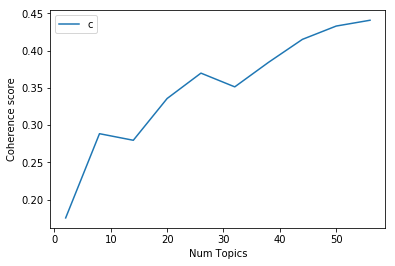

In [18]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1755
Num Topics = 8  has Coherence Value of 0.2885
Num Topics = 14  has Coherence Value of 0.2796
Num Topics = 20  has Coherence Value of 0.3357
Num Topics = 26  has Coherence Value of 0.3697
Num Topics = 32  has Coherence Value of 0.3513
Num Topics = 38  has Coherence Value of 0.3842
Num Topics = 44  has Coherence Value of 0.415
Num Topics = 50  has Coherence Value of 0.4328
Num Topics = 56  has Coherence Value of 0.4406


In [24]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(4,
  '0.043*"surge" + 0.022*"price" + 0.020*"scam" + 0.019*"consensus" + '
  '0.018*"continue" + 0.016*"case" + 0.016*"protocol" + 0.016*"chain" + '
  '0.012*"drop" + 0.012*"push"'),
 (5,
  '0.069*"market" + 0.058*"high" + 0.051*"trading" + 0.046*"ethereum" + '
  '0.033*"litecoin" + 0.031*"price" + 0.025*"bull" + 0.021*"bitcoincash" + '
  '0.021*"ripple" + 0.016*"nearly"'),
 (22,
  '0.022*"aicle" + 0.019*"say" + 0.015*"news" + 0.014*"transaction" + '
  '0.014*"anything" + 0.013*"bloomberg" + 0.013*"system" + 0.013*"beer" + '
  '0.012*"craig" + 0.012*"away"'),
 (24,
  '0.056*"price" + 0.035*"late" + 0.029*"news" + 0.017*"tech" + 0.016*"fraud" '
  '+ 0.013*"hacker" + 0.012*"range" + 0.011*"analysis" + '
  '0.010*"independent_life" + 0.010*"hack"'),
 (19,
  '0.025*"happen" + 0.022*"daily" + 0.017*"cash" + 0.017*"learn" + '
  '0.016*"keep" + 0.016*"date" + 0.014*"sign" + 0.014*"world" + 0.012*"soon" + '
  '0.011*"big"'),
 (11,
  '0.027*"news" + 0.025*"level" + 0.023*"hold" + 0.019*"crash

# Finding the dominant topic in each sentence


In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.3733,"price, late, news, tech, fraud, hacker, range,...",Bitcoin History Pa First Major Hack hps news b...
1,1,8.0,0.6025,"people, work, money, book, good, never, status...",working love Happy year bitcoin ethereum
2,2,4.0,0.8357,"surge, price, scam, consensus, continue, case,...",Hasn dawned that write about splinter groups w...
3,3,8.0,0.6795,"people, work, money, book, good, never, status...",Hmmm guess Bitcoin
4,4,15.0,0.4107,"source, medium_social, content, echobox, copyr...",Bitcoin like religion that kinda point post th...
5,5,1.0,0.5192,"status, craig_wright, satoshi, claim, give, ne...",make NFTs bitcoin
6,6,22.0,0.5490,"aicle, say, news, transaction, anything, bloom...",bitcoin ends year down nearly investors predic...
7,7,11.0,0.8691,"news, level, hold, crash, cointelegraph, want,...",year Lancaster woman murdered Philippines alle...
8,8,5.0,0.3481,"market, high, trading, ethereum, litecoin, pri...",Happy NewYears from everyone Here another year...
9,9,14.0,0.1777,"service, wallet, pay, send, suppo, minute, ope...",Original Bitcoin chance being global sound mon...


# the most representative document for each topic

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9199,"china, mining, bloom, point, dollar, climb, wh...",Would like know more abot bitcoin other crypto...
1,1.0,0.9434,"status, craig_wright, satoshi, claim, give, ne...",NYBA training weighraining liftingheavy heavyl...
2,2.0,0.9313,"woh, buy, invest, lose, investor, investment, ...",MondayWisdom Bitcoin Investment KnowHow Made E...
3,3.0,0.9199,"blockchain, company, break, edition, different...",Sick same Bitcoin copycats These currencies so...
4,4.0,0.8798,"surge, price, scam, consensus, continue, case,...",Bitcoin back limelight prices surge above hps ...


# Topic distribution across documents

In [1]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics.head()

NameError: name 'df_topic_sents_keywords' is not defined

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda.html')
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.171955 -0.052849       1        1  5.946565
15    -0.081020 -0.085150       2        1  4.655613
14    -0.077233  0.010170       3        1  4.292287
16    -0.036531 -0.098578       4        1  4.282586
2     -0.035828  0.083741       5        1  4.238646
5      0.286156 -0.060897       6        1  4.185477
25     0.202292 -0.082405       7        1  4.064724
22    -0.073506  0.084708       8        1  4.027747
1     -0.097715 -0.021791       9        1  3.976449
9     -0.010155 -0.134428      10        1  3.964704
11     0.002218  0.034584      11        1  3.880198
7     -0.049356  0.109024      12        1  3.816549
19    -0.042182  0.017971      13        1  3.778433
4      0.069213 -0.002576      14        1  3.765702
21    -0.090119 -0.003801      15        1  3.756952
12    -0.085175 -0.011863      16        1  3.675025
20     0.069031  0.139352      17        1  3.642935
23    -0.078760  0.006765      18        1  3.579913
3     -0.076459 -0.087554      19        1  3.536369
10     0.060849 -0.083497      20        1  3.504350
24     0.069321  0.075018      21        1  3.418464
18     0.022242 -0.086654      22        1  3.396930
0      0.039819  0.151910      23        1  3.366601
17     0.085979  0.175150      24        1  3.313665
13     0.103959 -0.087635      25        1  3.165921
6     -0.005084  0.011284      26        1  2.767198, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
176   Default  2236.000000        blockchain  2236.000000  30.0000  30.0000
94    Default  1541.000000            market  1541.000000  29.0000  29.0000
138   Default  1781.000000             price  1781.000000  28.0000  28.0000
62    Default   782.000000              gold   782.000000  27.0000  27.0000
77    Default   973.000000              high   973.000000  26.0000  26.0000
513   Default   622.000000           trading   622.000000  25.0000  25.0000
875   Default   566.000000            accept   566.000000  24.0000  24.0000
4946  Default   520.000000           binance   520.000000  23.0000  23.0000
267   Default   607.000000              buff   607.000000  22.0000  22.0000
470   Default   718.000000             trade   718.000000  21.0000  21.0000
375   Default   471.000000             china   471.000000  20.0000  20.0000
280   Default   804.000000            mining   804.000000  19.0000  19.0000
378   Default   462.000000             surge   462.000000  18.0000  18.0000
4     Default   824.000000          ethereum   824.000000  17.0000  17.0000
1288  Default   478.000000              rise   478.000000  16.0000  16.0000
180   Default   490.000000          litecoin   490.000000  15.0000  15.0000
252   Default   965.000000          exchange   965.000000  14.0000  14.0000
414   Default   748.000000            future   748.000000  13.0000  13.0000
922   Default   502.000000               woh   502.000000  12.0000  12.0000
502   Default   538.000000            source   538.000000  11.0000  11.0000
136   Default   643.000000           payment   643.000000  10.0000  10.0000
142   Default   475.000000              late   475.000000   9.0000   9.0000
3     Default  1445.000000              news  1445.000000   8.0000   8.0000
3231  Default   319.000000             pizza   319.000000   7.0000   7.0000
523   Default   378.000000            update   378.000000   6.0000   6.0000
1207  Default   323.000000                hp   323.000000   5.0000   5.0000
107   Default  1243.000000            people  1243.000000   4.0000   4.0000
215   Default   884.000000               use   884.000000   3.0000   3.0000
439   Default   344.000000               buy   344.000000   2.0000   2.0000
1669  Default   316.000000          facebook   316.000000   1.0000   1.0000
...       ...          ...               